# Load Database Tables into Python

In [2]:
# Import Dependencies
import sqlalchemy
from sqlalchemy import create_engine
from config import db_password_susie
import pandas as pd

In [3]:
# Import dependencies
from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Activation
from keras.utils import to_categorical
from keras.layers.advanced_activations import LeakyReLU

import matplotlib.pyplot as plt
import numpy as np


Using TensorFlow backend.


In [4]:
# read data from Postgres Database
engine = create_engine('postgresql://postgres:'+ db_password_susie +'@localhost:5432/AI_Music_DB')

instruments_df = pd.read_sql_table('Instruments_Spectrogram_Table',engine)
instruments_df.head(5)

,index,Spectrogram,File_Path,Instrument_name
0,0,"[[0.0144, 0.0823257, 0.5346, 0.650745, 0.55175...",Brass/Bass_Tuba/ordinario/BTb-ord-F#1-pp-N-N.wav,Bass Tuba
1,1,"[[0.157734, 0.250661, 0.497269, 0.623247, 0.53...",Brass/Bass_Tuba/ordinario/BTb-ord-G1-pp-N-R100...,Bass Tuba
2,2,"[[0.771829, 1.0, 1.0, 1.0, 1.0, 0.410719, 0.34...",Brass/Bass_Tuba/ordinario/BTb-ord-G#1-pp-N-T16...,Bass Tuba
3,3,"[[0.611689, 0.147743, 1.0, 0.439109, 0.478873,...",Brass/Bass_Tuba/ordinario/BTb-ord-A1-pp-N-T23d...,Bass Tuba
4,4,"[[0.0485143, 0.275178, 1.0, 0.413771, 0.624172...",Brass/Bass_Tuba/ordinario/BTb-ord-A#1-pp-N-N.wav,Bass Tuba


In [5]:
# Convert Spectrograms from list to ndarray
instruments_df['Spectrogram'] = instruments_df['Spectrogram'].apply(lambda x: np.array(x))

type(instruments_df['Spectrogram'].iloc[0])

numpy.ndarray

# MODEL - Neural Network 

In [6]:
# Create train and test data sets
X_series1 = instruments_df["Spectrogram"]
y1 = instruments_df["Instrument_name"]

In [7]:
# Parameters

channels = 1 # number of audio channels
spectrogram_shape1 = X_series1[1].shape + (channels,)
batch1 = spectrogram_shape1[1]

In [8]:
X_series1[1].shape

(44, 128)

In [9]:
# Reshape X into size of spectrogram and convert to ndarray
X1 = np.array([i.reshape( (spectrogram_shape1) ) for i in X_series1])

In [10]:
# Encode pitches

le = LabelEncoder() 
y1 = le.fit_transform(y1)

# Split dataset
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, random_state=78)

# Reshape for model
# X_train = np.array([X.reshape(20, 20, 1) for x in X_train])
# X_test = np.array([X.reshape(20, 20, 1) for x in X_test])

# onehotencoder = OneHotEncoder() 
y_test_hot1 = to_categorical(y_test1)
y_train_hot1 = to_categorical(y_train1)

In [11]:
# Troubleshooting queries
type(X_train1[1])
X_train1[1].shape
# X_train[1]

(44, 128, 1)

In [12]:
# Model
instruments_model = Sequential()
instruments_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',input_shape=(spectrogram_shape1),padding='same'))
instruments_model.add(LeakyReLU(alpha=0.1))
instruments_model.add(MaxPooling2D((2, 2),padding='same'))
instruments_model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
instruments_model.add(LeakyReLU(alpha=0.1))
instruments_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
instruments_model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
instruments_model.add(LeakyReLU(alpha=0.1))                  
instruments_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
instruments_model.add(Flatten())
instruments_model.add(Dense(128, activation='linear'))
instruments_model.add(LeakyReLU(alpha=0.1))                  
instruments_model.add(Dense(14, activation='softmax')) ########### make 14 variable for instrument num

In [13]:
instruments_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [14]:
instruments_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 44, 128, 32)       320       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 44, 128, 32)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 64, 64)        18496     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 22, 64, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 32, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 32, 128)      

In [15]:
instruments_train = instruments_model.fit(X_train1, y_train_hot1, batch_size=batch1,epochs=8,verbose=1,validation_data=(X_test1, y_test_hot1))

Train on 2184 samples, validate on 729 samples
Epoch 1/8
2184/2184 [==============================] - 17s 8ms/step - loss: 2.2053 - accuracy: 0.3036 - val_loss: 2.1385 - val_accuracy: 0.2510
Epoch 2/8
2184/2184 [==============================] - 16s 7ms/step - loss: 1.5352 - accuracy: 0.4817 - val_loss: 1.2576 - val_accuracy: 0.5528
Epoch 3/8
2184/2184 [==============================] - 15s 7ms/step - loss: 1.0796 - accuracy: 0.6342 - val_loss: 1.1234 - val_accuracy: 0.6132
Epoch 4/8
2184/2184 [==============================] - 15s 7ms/step - loss: 0.8659 - accuracy: 0.7005 - val_loss: 0.8594 - val_accuracy: 0.7160
Epoch 5/8
2184/2184 [==============================] - 15s 7ms/step - loss: 0.6591 - accuracy: 0.7715 - val_loss: 0.8050 - val_accuracy: 0.7147
Epoch 6/8
2184/2184 [==============================] - 15s 7ms/step - loss: 0.5246 - accuracy: 0.8182 - val_loss: 0.8116 - val_accuracy: 0.7257
Epoch 7/8
2184/2184 [==============================] - 15s 7ms/step - loss: 0.4710 - accu

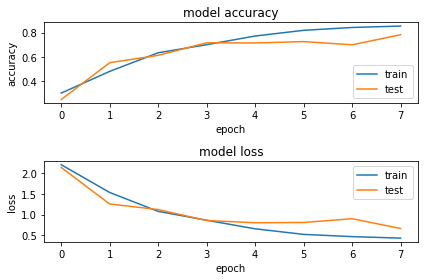

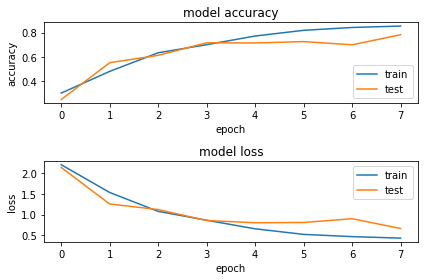

In [16]:
# plotting the metrics
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(instruments_train.history['accuracy'])
plt.plot(instruments_train.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.subplot(2,1,2)
plt.plot(instruments_train.history['loss'])
plt.plot(instruments_train.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.tight_layout()
fig

In [17]:
# Export our model to HDF5 file
import os
# make a new directory 
os.makedirs('../Result_models/',exist_ok=True)
# save trained model
instruments_model.save("../Result_models/trained_intruments_model.h5")

In [21]:
# implements binary protocols for serialization a Python object structure
import pickle

# save in binary format,wb replace old file with new one
with open('../Result_models/PKL_trained_instruments_model.pkl', 'wb') as instruments_model_file:
    pickle.dump(instruments_model, instruments_model_file)

In [22]:
# return file for troubleshooting
with open('../Result_models/PKL_trained_instruments_model.pkl', 'rb') as instruments_model_file:
    instruments_model_loaded = pickle.load(instruments_model_file)
instruments_model_loaded